In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from matplotlib.backends.backend_pdf import PdfPages
from statsmodels.tsa.arima.model import ARIMAResults
from pmdarima.arima import AutoARIMA
from statsmodels.tsa.seasonal import STL
from autots import AutoTS
from IPython.display import Image
import sys
import logging
from autots.models.model_list import model_lists
import json
from contextlib import contextmanager
import os
from helpers.constants import CONFIDENCE_INTERVAL, MIN_TRAINING_SAMPLES, TEST_YEAR, FORECASTING_LENGTH, PROP_IN_CI_DESIRED, PROP_IN_CI_ALLOWED, FORECASTED_YEARS
from helpers.auto_arima_modelling import evaluate_model
from helpers.autots_modelling import fit_autots_model
from helpers.autots_modelling import evaluate_AUTOTS_model


# Population growth estimation



# 1. Exploratory Data Analysis

In [2]:
# Reading a CSV file
df = pd.read_csv('data/FAOSTAT_animal_2022.csv')
# Convert 'Year' to datetime format with first day of the year
df['Year_datetime'] = pd.to_datetime(df['Year'], format='%Y').dt.to_period('Y').dt.start_time

df.dtypes


Domain Code                 object
Domain                      object
Area Code (M49)              int64
Area                        object
Element Code                 int64
Element                     object
Item Code (CPC)            float64
Item                        object
Year Code                    int64
Year                         int64
Unit                        object
Value                        int64
Flag                        object
Flag Description            object
Note                        object
Year_datetime       datetime64[ns]
dtype: object

Let's explore the origin of the population data, to see how many official figures we have vs estimated values per country and in total

In [3]:
df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note,Year_datetime
0,QCL,Crops and livestock products,4,Afghanistan,5111,Stocks,2132.0,Asses,1961,1961,An,1300000,A,Official figure,NaN,1961-01-01
1,QCL,Crops and livestock products,4,Afghanistan,5111,Stocks,2132.0,Asses,1962,1962,An,851850,A,Official figure,NaN,1962-01-01
2,QCL,Crops and livestock products,4,Afghanistan,5111,Stocks,2132.0,Asses,1963,1963,An,1001112,A,Official figure,NaN,1963-01-01
3,QCL,Crops and livestock products,4,Afghanistan,5111,Stocks,2132.0,Asses,1964,1964,An,1150000,E,Estimated value,NaN,1964-01-01
4,QCL,Crops and livestock products,4,Afghanistan,5111,Stocks,2132.0,Asses,1965,1965,An,1300000,A,Official figure,NaN,1965-01-01


### 1.1 Which type of animals are included in our dataset?

Since the diseases we are studying don't affect winged (bird) animals, we are removing them from the modelling data.

In [4]:
# Explore the actual animals we have values for
unique_values = df['Item'].unique()
print("We have the following animals with population counted:")
print(unique_values)

# Define the list of animals for analysis
animals_for_analysis = ['Asses', 'Camels', 'Cattle', 'Goats', 'Horses', 'Sheep', 'Buffalo', 'Swine / pigs', 'Other camelids']

# Filter the DataFrame to include only the selected animals
df = df[df['Item'].isin(animals_for_analysis)]
unique_values = df['Item'].unique()
print("After filtering winged animals we have the following animals with population counted:")
print(unique_values)


We have the following animals with population counted:
['Asses' 'Camels' 'Cattle' 'Chickens' 'Goats' 'Horses' 'Sheep' 'Buffalo'
 'Ducks' 'Geese' 'Swine / pigs' 'Turkeys' 'Other camelids']
After filtering winged animals we have the following animals with population counted:
['Asses' 'Camels' 'Cattle' 'Goats' 'Horses' 'Sheep' 'Buffalo'
 'Swine / pigs' 'Other camelids']


### 1.2 How many years are available 

In [5]:
# Explore the actual animals we have values for
unique_values = df['Year'].unique()
print("We have the following years:")
print(unique_values)

We have the following years:
[1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017 2018 2019 2020 2021 2022]


### 1.3  Origin of the population value 

Let's delve into the methodology behind obtaining population numbers across countries. These numbers are derived from various sources, including official figures, imputed values, and estimations from international organizations. By examining this data by country, we can assess its reliability.

Here are some key insights we can draw:

1. The data has minimal missing values, averaging around 2%. However, the 75th percentile indicates that most countries have no missing data. Some countries (althought very few) have 54% missing data. Should we retain countries with a high percentage of missing data (e.g Palestine)  or is it advisable to exclude them?
2. A significant portion of the data, averaging at 33%, is labeled as "estimated value." What exactly does this mean? Does it suggest the use of modeling techniques for estimation?
Approximately 54% of the data consists of "official figures."
3. Some countries exhibit entirely estimated values. Can we place confidence in such data? How should we handle countries with very low proportions of "official figure" values? And how might this affect the credibility of our model?

By addressing these questions, we can better understand the robustness of our dataset and its implications for our analysis.


In [6]:
# Grouping by 'Area' and 'Flag Description' and counting the occurrences, 
flag_counts = df.groupby(["Area", "Flag Description"]).size().unstack(fill_value=0)

#Calculate the total count for each 'Area'
total_counts = flag_counts.sum(axis=1)

# Calculate the percentage of each 'Flag Description' for each 'Area'
percentage_counts = ((flag_counts.div(total_counts, axis=0))*100).round(2)
percentage_counts.describe()

Flag Description,Estimated value,Figure from international organizations,Imputed value,"Missing value (data cannot exist, not applicable)",Official figure
count,208.000000,208.000000,208.000000,208.000000,208.000000
mean,30.378365,3.292356,5.518846,1.462019,59.348269
std,23.253222,5.112926,5.385557,5.546666,28.380042
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.450000,0.000000,0.642500,0.000000,35.212500
50%,28.415000,1.080000,4.410000,0.000000,62.650000
75%,47.730000,4.580000,8.767500,0.000000,83.477500
max,89.920000,37.300000,37.100000,53.230000,100.000000


##### 1.3.1 Official figure by country

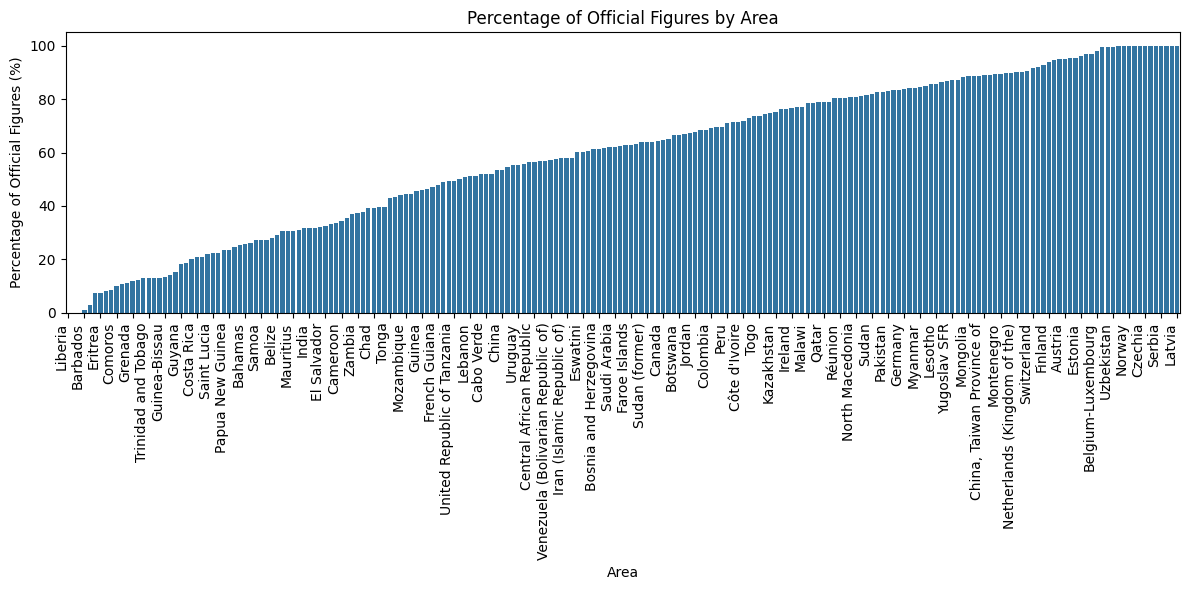

In [7]:
percentage_counts = percentage_counts.sort_values(by='Official figure')
percentage_counts = percentage_counts.reset_index()

# Plotting with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data = percentage_counts, x = "Area", y = "Official figure")
plt.title('Percentage of Official Figures by Area')
plt.xlabel('Area')
plt.ylabel('Percentage of Official Figures (%)')


# Selecting every 10th tick for display
x_ticks = percentage_counts.index[::3].tolist()
x_ticklabels = percentage_counts['Area'].iloc[::3].tolist()

# Set xticks and xticklabels
plt.xticks(x_ticks, x_ticklabels, rotation=90, ha='right')
plt.tight_layout()


##### 1.3.2 Estimated figure by country

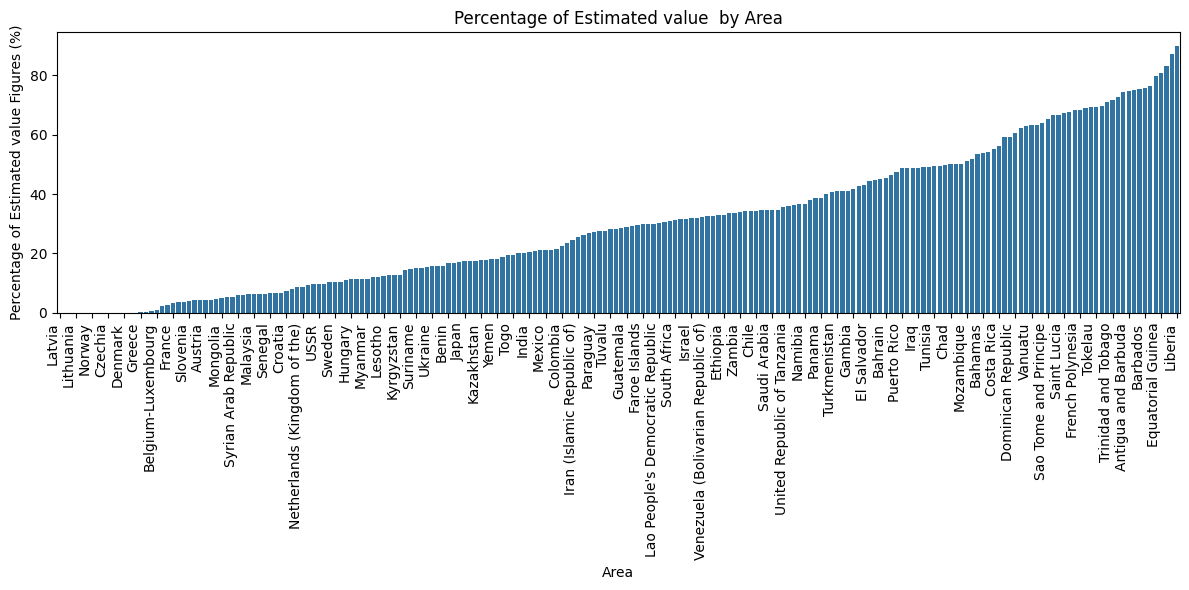

In [8]:
# sort by estimated value
percentage_counts = percentage_counts.sort_values(by='Estimated value')
percentage_counts = percentage_counts.reset_index()

# Plotting with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data = percentage_counts, x = "Area", y = "Estimated value")
plt.title('Percentage of Estimated value  by Area')
plt.xlabel('Area')
plt.ylabel('Percentage of Estimated value Figures (%)')

# Selecting every 10th tick for display
x_ticks = percentage_counts.index[::3].tolist()
x_ticklabels = percentage_counts['Area'].iloc[::3].tolist()

# Set xticks and xticklabels
plt.xticks(x_ticks, x_ticklabels, rotation=90, ha='right')
plt.tight_layout()


##### 1.3.3 Missing values by country

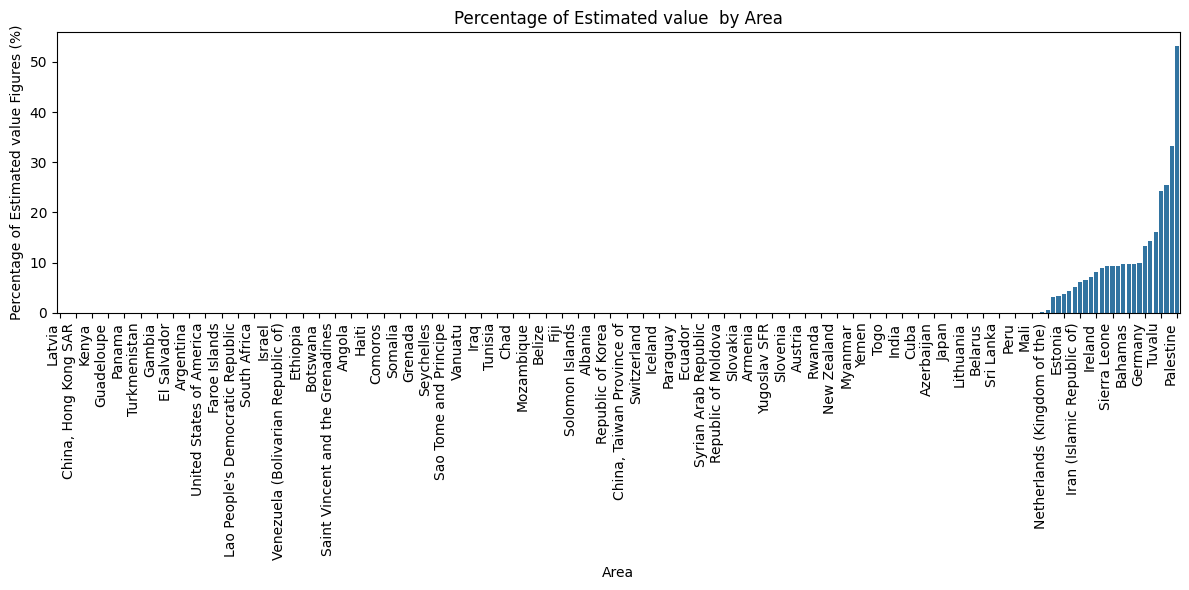

In [9]:
# sort by estimated value
percentage_counts = percentage_counts.sort_values(by='Missing value (data cannot exist, not applicable)')
percentage_counts = percentage_counts.reset_index()

# Plotting with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data = percentage_counts, x = "Area", y = "Missing value (data cannot exist, not applicable)")
plt.title('Percentage of Estimated value  by Area')
plt.xlabel('Area')
plt.ylabel('Percentage of Estimated value Figures (%)')

# Selecting every 10th tick for display
x_ticks = percentage_counts.index[::3].tolist()
x_ticklabels = percentage_counts['Area'].iloc[::3].tolist()

# Set xticks and xticklabels
plt.xticks(x_ticks, x_ticklabels, rotation=90, ha='right')
plt.tight_layout()

In [10]:
percentage_counts.tail(20)

Flag Description,level_0,index,Area,Estimated value,Figure from international organizations,Imputed value,"Missing value (data cannot exist, not applicable)",Official figure
188,69,124,Ukraine,15.67,0.46,7.37,5.07,71.43
189,96,93,Iran (Islamic Republic of),25.60,4.03,6.25,6.05,58.06
190,30,168,Mongolia,5.07,0.00,0.00,6.45,88.48
191,23,174,Montenegro,3.53,0.00,0.00,7.06,89.41
192,35,135,Ireland,6.27,8.45,0.27,8.17,76.84
193,138,61,Namibia,36.64,2.53,8.53,8.99,43.32
194,61,133,United Kingdom of Great Britain and Northern I...,12.58,0.65,1.29,9.35,76.13
195,173,38,Sierra Leone,55.16,0.97,6.45,9.35,28.06
196,95,94,Brunei Darussalam,24.52,6.45,1.61,9.35,58.06
197,98,87,Central African Republic,26.77,1.29,5.81,9.68,56.45


##### 1.3.4 Investigate years of data available
For running certain models the number of year points available would be critical for model performance, we can see we have 62 points of data available. The majority of the countries are above 58 datapoints and 25% of countries-animal may be below this. We can see that 10% of the countries-animal have less data points than 31

In [11]:
def count_years_of_data(df):
    """
    Count the number of years of data available for each country and animal type.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the time series data with columns 'Year', 'Area', 'Item', and 'Value'.

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the counts of years of data available for each country and animal type.
    """
    # Group by country and animal type, then count the unique years
    years_count = df.groupby(['Area', 'Item'])['Year'].nunique().reset_index()

    # Rename the columns for clarity
    years_count.columns = ['Country', 'AnimalType', 'YearsOfData']

    return years_count

years_data_count = count_years_of_data(df)
years_data_count.describe()

# Compute the 10th percentile
percentile_10 = years_data_count['YearsOfData'].quantile(0.1)

# Create the DataFrame description
description_with_percentile = years_data_count.describe()
# Add the 10th percentile to the DataFrame's description
description_with_percentile.loc['10th Percentile'] = percentile_10

description_with_percentile



,YearsOfData
count,1206.000000
mean,54.366501
std,14.922205
min,1.000000
25%,62.000000
50%,62.000000
75%,62.000000
max,62.000000
10th Percentile,31.000000


In [12]:
#Delete all China registries where Area is China, Hong Kong SAR   or China, mainland or China, Taiwan Province of leave just China
# List of values to drop from the 'Area' column
values_to_drop = ['China, Hong Kong SAR', 'China, mainland', 'China, Taiwan Province of']

# Drop rows where 'Area' column matches any of the values in the list
df= df[~df['Area'].isin(values_to_drop)]

# Recoding the country names as per R code
# Dictionary for recoding the values
recode_dict = {
    "Cabo Verde": "Cape Verde", 
    "UAE": "United Arab Emirates", 
    "Syria": "Syrian Arab Republic", 
    "DRC": "Democratic Republic of the Congo",
    "Namibia (zone)": "Namibia", 
    "Sao Tome et Principe": "Sao Tome and Principe", 
    "Guinea Bissau": "Guinea-Bissau", 
    "Iran": "Iran (Islamic Republic of)",
    "Tanzania": "United Republic of Tanzania",
    "Côte d'Ivoire": "Ivory Coast",
    "Belgium-Luxembourg": "Belgium", 
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom", 
    "Sudan (former)": "Sudan", 
    "Ethiopia PDR": "Ethiopia",
    "Myanmar": "Burma" 
}

df['Area'] = df['Area'].replace(recode_dict)
df['Area'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cape Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
       'Ivory Coast', 'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       'Czechoslovakia', "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji', 'Finland',
       'Fra

In [13]:
#order dataframe, to make sure years are in order
# Sort DataFrame 'df' by 'Area', 'Item', and 'Year' in ascending order inplace
df.sort_values(by=['Area', 'Item', 'Year'], ascending=True, inplace=True)

<b> Define countries and animals</b>

In [14]:
countries = df['Area'].unique()
animal_types = df['Item'].unique()

<b> Save dataframe</b>

In [15]:
# Save cleaned DataFrame to CSV
csv_file = 'data/AOSTAT_animal_2022_cleaned.csv'
df.to_csv(csv_file, index=False)

# 2. Modelling

## Proposed Step-by-Step Strategy

**Given the extended runtime due to the large amount of data (combination of country and animal), I propose the following step-by-step strategy:**

1. **Forecasting the LAST AVAILABLE VALUE:**
   - For models with insufficient training or testing data, or where all data values are constant, we will automatically forecast using the LAST AVAILABLE VALUE.

2. **ARIMA Modelling:**
   - Apply ARIMA modelling. If the confidence interval (%CI) is greater than 80%, we consider ARIMA successful and use it for forecasting.

3. **Applying AutoTS Without Ensemble:**
   - For the remaining models (about 50%, significantly reducing processing time), use AutoTS without ensemble.
   - AutoTS (no ensemble) will select from ETS, FB Prophet, and ARIMA. Models that meet the >80% CI criterion are considered successful and are forecasted using AutoTS without ensemble.

4. **Applying AutoTS With Ensemble:**
   - For models that don't pass the threshold with AutoTS no ensemble, run AutoTS with ensemble.
   - The ensemble approach combines various models, including machine learning models. Models that meet the >80% CI criterion are considered successful and are forecasted using AutoTS with ensemble.

5. **Fallback to LAST AVAILABLE VALUE:**
   - For models that still don't meet the threshold after applying AutoTS with ensemble, or those that produce errors, we will conclude that a suitable model wasn't found and revert to forecasting using the LAST AVAILABLE VALUE.

**Rationale:**
- This step-by-step "filter" approach saves a lot of computing time and adheres to the principle of simplicity and effectiveness.
- We lack another comparison measure unless we compare ARIMA against AutoTS and AutoTS ensemble in terms of Mean Absolute Error (MAE). If guided by %CI, this approach seems reasonable. Checking additional metrics would require running all combinations for all models, which appears excessive.

### AUTOARIMA MODEL
ARIMA models capture the patterns and trends present in time series data by modeling the relationship between the variable of interest and its past values, past forecast errors, and differenced data to achieve stationarity

### AUTOSS models
#### 1. Exponential Smoothing Methods:

Holt-Winters Exponential Smoothing: Suitable for data with trend and seasonality. It can provide reliable forecasts and is capable of handling extrapolation well.
https://www.analyticsvidhya.com/blog/2021/08/holt-winters-method-for-time-series-analysis/

#### 2.  Facebook profet method 
 Prophet is a popular open-source library designed for forecasting time series data with an emphasis on simplicity, flexibility, and automatic handling of common time series issues such as seasonality, holidays, and missing data.
 Prophet is particularly well-suited for forecasting tasks where the data exhibit strong seasonal patterns and multiple sources of uncertainty. It employs an additive model that decomposes the time series into trend, seasonality, and holiday components, allowing for more interpretable forecasts.

#### 3. Hybrid ensemble Models:
- Ensemble Methods: Combine forecasts from multiple models, such as ARIMA, machine learning models, and exponential smoothing methods, to create a more robust and accurate forecast.



### 2.1 ARIMA model
ARIMA models capture the patterns and trends present in time series data by modeling the relationship between the variable of interest and its past values, past forecast errors, and differenced data to achieve stationarity

In ARIMA, the autoregressive (AR) component models the relationship between the variable of interest and its past values, capturing the serial correlation in the data. The moving average (MA) component models the relationship between the current value and past forecast errors, capturing the random fluctuations in the data. The integration (I) component involves differencing the data to achieve stationarity, removing trends and seasonality.

ARIMA(p, d, q)
- p:  number of autoregesssive lags
- q: number of moving average lags
- d: order of differenciating 

We will use the auto_arima as it is 
Limitations:
- ARIMA is sensitive to outliers and can be computationally intensive, especially for large datasets or high-order models.
- ARIMA does not account for exogenous variables or external factors that may influence the time series, limiting its predictive capabilities in certain contexts
      - Is there any other time series that could be incorporated to help model growth (e.g something related to the economy or number of natural disasters or something else???)
- ARIMA doesn't account for seasonality of the data, maybe in our case it doesn't matter as we have yearly data rather than monthly so really no seasonality?
- ARIMA models may struggle with sudden changes or breaks in the trend (also known as structural breaks). These could be due to events like economic crises, natural disasters, policy changes, or other abrupt disruptions.
Such changes can lead to poor model performance because ARIMA assumes that the underlying process generating the data remains consistent over time.

Some assumptions:
- It is assumed that in order to generate reliable ARIMA predictions we need at least 50 observations (so 50 years of data)
  *** The recommendation of having at least 50 data points for ARIMA modeling is based on practical experience and rules of thumb in time series analysis rather than a strict theoretical minimum
  *** Box-Jenkins Methodology: The foundational work by George Box and Gwilym Jenkins on ARIMA modeling, while not specifying a strict minimum, implies that more data points are generally better for reliable parameter estimation and model validation. The common practice derived from their work suggests having a reasonable amount of data, typically 50 or more observations.
- If the time-series is constant and ARMA (0,0,0) model has been fitted

Assumptions made for this analysis:
- Eventhough it is recommended that the ARIMA model has at least 50 observations in order to run better, for this study only country-animal combinations with less that 20 years of data have been discarded. 
- To evaluate model performance the 95% CI has been used in the following way:
- The percentage of datapoints outside the CI have been counted.
     - The number of models with >20% of values outside the CI have been counted
     - The number of models with >30% of values outside the CI have been counted
     - The combination of country - animal that met both requirements above (i.e outside 95% CI> 20% or > 30%) have been stored for future evaluation
- Models where the prediction has returned a flat line (all values are the same), have not been considered into the model an a flag constant_prediction has been added to evaluate this models and why they may have failed
- The column Flag results reflects with type of model has been fitted (AutoArima, constant, or No Data and Error), this is as well to check how many models couldn't been run because there was not enough data, how many models encountered and error, and how many models the training data was completely constant.
*** Note this parameters can be change by modifying CONSTANT variables at the beggining of the script



#### 2.1.1 Sample size requirement for proper ARIMA estimation

- As per bellow we have 46 occurrences bellow 20 datapoints
- We also have 234 occurrences bellow 50 datapoints 
 

In [16]:
# list and count the number of countries with less than 20 years of data
years_data_count_sorted = years_data_count.sort_values(by='YearsOfData', ascending=True)
number_of_countries_less_than20 = (years_data_count_sorted[years_data_count_sorted['YearsOfData']<MIN_TRAINING_SAMPLES])['Country'].count()
number_of_countries_less_than20 = (years_data_count_sorted[years_data_count_sorted['YearsOfData']<MIN_TRAINING_SAMPLES])['Country'].count()

print(f"The number of countries-species with less than {MIN_TRAINING_SAMPLES} data points are {number_of_countries_less_than20}, and they are listed bellow")
(years_data_count_sorted[years_data_count_sorted['YearsOfData']<MIN_TRAINING_SAMPLES])

The number of countries-species with less than 20 data points are 53, and they are listed bellow


,Country,AnimalType,YearsOfData
262,Croatia,Buffalo,1
751,Netherlands (Kingdom of the),Buffalo,1
309,Denmark,Goats,2
1033,Sweden,Goats,3
850,Portugal,Buffalo,5
636,Lithuania,Buffalo,5
880,Romania,Buffalo,5
607,Latvia,Buffalo,5
971,Slovenia,Buffalo,5
642,Luxembourg,Buffalo,5


In [17]:
# list and count the number of countries with less than 20 years of data
years_data_count_sorted = years_data_count.sort_values(by='YearsOfData', ascending=True)
number_of_countries_less_than20 = (years_data_count_sorted[years_data_count_sorted['YearsOfData']<50])['Country'].count()
number_of_countries_less_than20 = (years_data_count_sorted[years_data_count_sorted['YearsOfData']<50])['Country'].count()

print(f"The number of countries with less than 50 data points are {number_of_countries_less_than20}, and they are listed bellow")
(years_data_count_sorted[years_data_count_sorted['YearsOfData']<50]).head(60)

The number of countries with less than 50 data points are 264, and they are listed bellow


,Country,AnimalType,YearsOfData
262,Croatia,Buffalo,1
751,Netherlands (Kingdom of the),Buffalo,1
309,Denmark,Goats,2
1033,Sweden,Goats,3
850,Portugal,Buffalo,5
636,Lithuania,Buffalo,5
880,Romania,Buffalo,5
607,Latvia,Buffalo,5
971,Slovenia,Buffalo,5
642,Luxembourg,Buffalo,5


#### 2.1.2 ARIMA model evaluation

In [18]:
# Define the number of combinations to select
num_combinations = 7

# Randomly select a subset of country-animal combinations
# Get unique combinations of animal types and countries from the DataFrame
unique_combinations = df[['Area', 'Item']].drop_duplicates()
# Randomly select a subset of unique country-animal combinations
random_combinations = unique_combinations.sample(num_combinations, replace=False, random_state=123)

#ramdom_combinations = [('Thailand', 'Sheep'),
# ('Kenya', 'Goats')]
# Evaluate the models
test_start_year = 2013  # Specify the year to start testing
evaluation_results = {}

df_arima = df.copy()

with PdfPages('ARIMA_forecast_plots.pdf') as pdf:
    for index, row in unique_combinations.iterrows():
        title_color = 'red'
        country = row['Area']
        animal_type = row['Item']
        results = evaluate_model(df_arima, country, animal_type)
        model_type, constant_prediction, mean_actual, var_actual, mae, mse, test_value, test_year, predictions, conf_int, proportion_in_ci = results
        evaluation_results[(country, animal_type)] = (model_type, constant_prediction, mean_actual, var_actual, mae, mse, proportion_in_ci)
    
        # predictions the DataFrame for the specific country and animal type combination
        filtered_df = df_arima[(df_arima['Area'] == country) & (df_arima['Item'] == animal_type)]
        # Plot actual vs. predicted values
        plt.figure(figsize=(8, 4))
        plt.plot(filtered_df['Year'], filtered_df['Value'], label='Actual Data')
        
        if predictions is not None:
            plt.plot(test_year, predictions, label='Predicted Data')
            # Plot confidence intervals ensuring first that they are not Nonw
            if conf_int is not None:
                if not constant_prediction:
                    title_color = 'green'
                plt.fill_between(test_year, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='Confidence Interval')
            
        plt.xlabel('Year')
        plt.ylabel('Population')
        title_text_obj = plt.title(f'{model_type} prediction for {country} - {animal_type}')
        title_text_obj.set_color(title_color)
        plt.legend()
        plt.grid(True)
    
        # Save the current plot to the PDF
        pdf.savefig()
        plt.close()
  



Time series for Australia - Buffalo is constant. Fitting ARMA(0,0,0) model.


<b> Results of the ARIMA model on trainint-test data </b>

In [19]:
# Convert the dictionary to a DataFrame
data = {
    'Country': [],
    'Animal Type': [],
    'Flag results': [],
    'Constant Prediction': [],
    'Mean Actual': [],
    'Variance Actual': [],
    'MAE': [],
    'MSE': [],
    'Proportion in CI': []
}

for (country, animal_type), (model_type, constant_prediction, mean_actual, var_actual, mae, mse, proportion_in_ci) in evaluation_results.items():
    data['Country'].append(country)
    data['Animal Type'].append(animal_type)
    data['Flag results'].append(model_type)
    data['Constant Prediction'].append(constant_prediction)
    data['Mean Actual'].append(mean_actual)
    data['Variance Actual'].append(var_actual)
    data['MAE'].append(mae)
    data['MSE'].append(mse)
    data['Proportion in CI'].append(proportion_in_ci)

df_results = pd.DataFrame(data)
# Sort the DataFrame by 'Proportion in CI' column in ascending order
df_results_sorted = df_results.sort_values(by='Proportion in CI', ascending = True)

# Save the DataFrame to an Excel file
excel_file = 'ARIMA_evaluation_results.xlsx'
df_results_sorted.to_excel(excel_file, index=False)

print(f"DataFrame saved to {excel_file}")
df_results_sorted.head(50)

DataFrame saved to ARIMA_evaluation_results.xlsx


,Country,Animal Type,Flag results,Constant Prediction,Mean Actual,Variance Actual,MAE,MSE,Proportion in CI
87,Belarus,Goats,AutoARIMA,False,6.232000e+04,4.057956e+07,1.891000e+04,4.601382e+08,0.0
769,Oman,Camels,AutoARIMA,False,2.659131e+05,2.541215e+08,1.176543e+05,1.390812e+10,0.0
348,Ethiopia,Goats,AutoARIMA,False,3.868882e+07,9.805447e+13,1.621940e+07,3.644422e+14,0.0
88,Belarus,Horses,AutoARIMA,False,4.821000e+04,4.134499e+08,1.087590e+05,1.696584e+10,0.0
751,Nigeria,Goats,AutoARIMA,False,7.893846e+07,3.742406e+13,2.453480e+07,7.239456e+14,0.0
614,Lithuania,Sheep,AutoARIMA,False,1.346476e+05,6.944622e+08,8.990115e+04,9.244872e+09,0.0
628,Malawi,Asses,AutoARIMA,False,7.209700e+03,9.798798e+05,4.170948e+03,1.812313e+07,0.0
569,Kyrgyzstan,Asses,AutoARIMA,False,4.099350e+04,3.228654e+08,3.573493e+04,1.565626e+09,0.0
60,Azerbaijan,Cattle,AutoARIMA,False,2.477279e+06,9.397703e+08,2.389934e+05,7.852233e+10,0.0
834,Qatar,Sheep,AutoARIMA,False,8.092545e+05,4.627245e+10,4.704272e+05,2.582596e+11,0.0


<b> Create table for evaluation </b><br><br>
Create a final table that Contains:
- Country
- Animal Type
- Prediction Method Flag:
    - AUTOARIMA: an AUTOARIMA model was fitted
    - NoData: No enough samples as required by MIN_TRAINING_SAMPLES to train the algorithm
    - Constant-Prediction: All prediction was constant
    - NoTestData: There was not enough Data
- Forecast:
    - MODEL: if data can been forecasted from modelling as there were no errors on prediction method flag and there was a  defined by threshold predicted values within the specified CI.
    - LASTVALUE: If all the requirements are not met data will be forecasted using the last available value

In [20]:
# Define the path to your Excel file
excel_file = 'ARIMA_evaluation_results.xlsx'

# Load the Excel file into a DataFrame
df_results = pd.read_excel(excel_file)


# Step 1: Merge Flag results and Constant Prediction into one column
df_results['Prediction Method'] = df_results.apply(lambda row: f"{row['Flag results']}-Constant-Prediction" if row['Flag results'] == 'AutoARIMA' and row['Constant Prediction'] else row['Flag results'], axis=1)

# Step 2: Create Predictions column based on conditions
df_results['Predictions'] = df_results.apply(lambda row: 'MODEL' if row['Flag results'] == 'AutoARIMA' and not row['Constant Prediction'] and row['Proportion in CI'] >= PROP_IN_CI_DESIRED else 'LASTVALUE', axis=1)

df_results['Flag'] = df_results['Prediction Method']

# Filter and update the 'Prediction Method' column
df_results.loc[(df_results['Proportion in CI'] < PROP_IN_CI_DESIRED) & (df_results['Prediction Method'] == 'AutoARIMA'), 'Flag'] = 'AUTOARIMA-InsideCINotMet'

# Create a new column 'Model_type' based on the 'Flag results' column
df_results['Model_type'] = df_results['Flag results'].apply(lambda x: 'AutoARIMA' if x == 'AutoARIMA' else 'None')


df_results.tail(15)

,Country,Animal Type,Flag results,Constant Prediction,Mean Actual,Variance Actual,MAE,MSE,Proportion in CI,Prediction Method,Predictions,Flag,Model_type
1153,United States of America,Cattle,AutoARIMA,True,92203890.1,5.074089e+12,2.186970e+06,5.655969e+12,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1154,Uruguay,Cattle,AutoARIMA,True,11656064.3,6.950713e+10,2.948643e+05,1.250886e+11,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1155,Uruguay,Swine / pigs,AutoARIMA,True,178379.3,7.378767e+08,3.122070e+04,1.483233e+09,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1156,Vanuatu,Horses,AutoARIMA,True,5014.9,2.225892e+06,1.254300e+03,2.973725e+06,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1157,Venezuela (Bolivarian Republic of),Horses,AutoARIMA,True,524170.8,7.846796e+06,4.388130e+03,2.631780e+07,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1158,Viet Nam,Buffalo,AutoARIMA,True,2425805.8,1.372576e+10,2.020072e+05,5.316009e+10,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1159,Viet Nam,Cattle,AutoARIMA,True,5770783.5,2.099124e+11,6.234224e+05,5.775767e+11,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1160,Yemen,Horses,AutoARIMA,True,1961.0,5.222889e+03,7.400000e+01,6.636600e+03,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1161,Yugoslav SFR,Asses,NoTestData,False,NaN,NaN,NaN,NaN,NaN,NoTestData,LASTVALUE,NoTestData,None
1162,Yugoslav SFR,Buffalo,NoTestData,False,NaN,NaN,NaN,NaN,NaN,NoTestData,LASTVALUE,NoTestData,None


In [21]:
# Save the DataFrame to an Excel file
excel_file = 'ARIMA_evaluation_results_all.xlsx'
df_results.to_excel(excel_file, index=False)


#### 2.1.2.1 Count Models with Proportions in CI

In [22]:
df_sorted = df_results[df_results['Proportion in CI'].notna()]
# Count models with proportion in CI > PROP_IN_CI_DESIRED and > PROP_IN_CI_ALLOWED
count_greater_than_p_desired = df_sorted[df_sorted['Proportion in CI'] >= PROP_IN_CI_DESIRED].shape[0]
count_greater_than_p_allowed = df_sorted[df_sorted['Proportion in CI'] >= PROP_IN_CI_ALLOWED].shape[0]

# Calculate the proportion of models with Proportion in CI > PROP_IN_CI_DESIRED% and > PROP_IN_CI_ALLOWED%
proportion_in_ci_pdesired = ((df_sorted['Proportion in CI'] >= PROP_IN_CI_DESIRED).mean() * 100).round(2)
# Calculate the proportion of models with Proportion in CI > ci_threshold
proportion_in_ci_pallowed = ((df_sorted['Proportion in CI'] >= PROP_IN_CI_ALLOWED).mean() * 100).round(2)


print(f"Models with proportion in CI >= {PROP_IN_CI_DESIRED*100}%: {count_greater_than_p_desired} and the proportion of models is {proportion_in_ci_pdesired}")
print(f"Models with proportion in CI >=  {PROP_IN_CI_ALLOWED*100}%: {count_greater_than_p_allowed} and the proportion of models is {proportion_in_ci_pallowed}")

# perform this per specie 


Models with proportion in CI >= 80.0%: 599 and the proportion of models is 74.32
Models with proportion in CI >=  70.0%: 627 and the proportion of models is 77.79


<b> Look at whether there is a pattern accross countries </b> <br>
There is a huge difference on how the model performs accross the different countries, perhaps something that should be explored by looking at the plots?

In [23]:
# Initialize lists to store results
countries = []
count_desired = []
proportion_desired = []
count_allowed = []
proportion_allowed = []
total_count = []

# Group the DataFrame by 'Animal'
grouped = df_sorted.groupby('Country')

# Iterate over each group
for country, group in grouped:
    count_greater_than_desired = group[group['Proportion in CI'] >= PROP_IN_CI_DESIRED].shape[0]
    count_greater_than_allowed = group[group['Proportion in CI'] >= PROP_IN_CI_ALLOWED].shape[0]
    
    proportion_in_ci_desired = ((group['Proportion in CI'] >= PROP_IN_CI_DESIRED).mean() * 100).round(2)
    proportion_in_ci_allowed = ((group['Proportion in CI'] >= PROP_IN_CI_ALLOWED).mean() * 100).round(2)
    
    countries.append(country)
    count_desired.append(count_greater_than_desired)
    proportion_desired.append(proportion_in_ci_desired)
    count_allowed.append(count_greater_than_allowed)
    proportion_allowed.append(proportion_in_ci_allowed)
    total_count.append(group.shape[0])

# Create a new DataFrame to store the results
results = pd.DataFrame({
    'Country': countries,
    'Total Count': total_count,
    f'Count >= {PROP_IN_CI_DESIRED*100}%': count_desired,
    f'Proportion >= {PROP_IN_CI_DESIRED*100}%': proportion_desired,
    f'Count >= {PROP_IN_CI_ALLOWED*100}%': count_allowed,
    f'Proportion >= {PROP_IN_CI_ALLOWED*100}%': proportion_allowed
})

# Sort the DataFrame based on the 'Proportion > ALLOWED%' column in ascending order
results_sorted = results.sort_values(by=f'Proportion >= {PROP_IN_CI_ALLOWED*100}%', ascending=True)


results_sorted.tail(50)

,Country,Total Count,Count >= 80.0%,Proportion >= 80.0%,Count >= 70.0%,Proportion >= 70.0%
12,Bangladesh,4,4,100.0,4,100.0
19,Bolivia (Plurinational State of),7,7,100.0,7,100.0
80,Indonesia,5,5,100.0,5,100.0
41,Croatia,4,4,100.0,4,100.0
62,France,4,4,100.0,4,100.0
106,Mauritania,4,4,100.0,4,100.0
105,Malta,4,4,100.0,4,100.0
103,Malaysia,4,3,75.0,4,100.0
64,Gabon,4,4,100.0,4,100.0
101,Madagascar,3,3,100.0,3,100.0


<b> Look at whether there is a pattern across species </b> <br>
It doesn't seem to be a pattern across different species, camels and buffalos have the lowest percentage but not excessively different from the rest

In [24]:

# Initialize lists to store results
animals = []
count_desired = []
proportion_desired = []
count_allowed = []
proportion_allowed = []
total_count = []

# Group the DataFrame by 'Animal'
grouped = df_sorted.groupby('Animal Type')

# Iterate over each group
for animal, group in grouped:
    count_greater_than_desired = group[group['Proportion in CI'] > PROP_IN_CI_DESIRED].shape[0]
    count_greater_than_allowed = group[group['Proportion in CI'] > PROP_IN_CI_ALLOWED].shape[0]
    
    proportion_in_ci_desired = ((group['Proportion in CI'] >= PROP_IN_CI_DESIRED).mean() * 100).round(2)
    proportion_in_ci_allowed = ((group['Proportion in CI'] >= PROP_IN_CI_ALLOWED).mean() * 100).round(2)
    
    animals.append(animal)
    count_desired.append(count_greater_than_desired)
    proportion_desired.append(proportion_in_ci_desired)
    count_allowed.append(count_greater_than_allowed)
    proportion_allowed.append(proportion_in_ci_allowed)
    total_count.append(group.shape[0])

# Create a new DataFrame to store the results
results = pd.DataFrame({
    'Animal': animals,
    'Total Count': total_count,
    f'Count >= {PROP_IN_CI_DESIRED*100}%': count_desired,
    f'Proportion >= {PROP_IN_CI_DESIRED*100}%': proportion_desired,
    f'Count >= {PROP_IN_CI_ALLOWED*100}%': count_allowed,
    f'Proportion >= {PROP_IN_CI_ALLOWED*100}%': proportion_allowed
})

results

,Animal,Total Count,Count >= 80.0%,Proportion >= 80.0%,Count >= 70.0%,Proportion >= 70.0%
0,Asses,83,61,74.70,62,78.31
1,Buffalo,36,26,75.00,27,77.78
2,Camels,32,21,75.00,24,75.00
3,Cattle,145,106,78.62,114,82.07
4,Goats,135,89,68.89,93,76.30
5,Horses,123,88,74.80,92,75.61
6,Other camelids,1,1,100.00,1,100.00
7,Sheep,125,79,71.20,89,74.40
8,Swine / pigs,126,91,76.98,97,80.16


#### 2.1.2.2 Describe Counts of Constant Prediction Models

In [25]:
# Describe counts of constant prediction models
# Count occurrences of constant predictions
df_sorted = df_results
constant_prediction_counts = df_sorted['Constant Prediction'].value_counts()

# Calculate proportions
total_predictions = len(df_sorted)
flag_results_proportions = ((constant_prediction_counts / total_predictions) * 100).round(2)

print("Counts of Constant Prediction:")
print(constant_prediction_counts)

print("\nProportion of Constant Prediction:")
print(flag_results_proportions)

Counts of Constant Prediction:
Constant Prediction
False    899
True     269
Name: count, dtype: int64

Proportion of Constant Prediction:
Constant Prediction
False    76.97
True     23.03
Name: count, dtype: float64


#### 2.1.2.3 Describe Counts for Each 'Flag results' Category

In [26]:

# Count occurrences of each 'Flag results' category
flag_results_counts = df_sorted['Flag results'].value_counts()

# Calculate proportions
total_results = len(df_sorted)
flag_results_proportions = ((flag_results_counts / total_results) * 100).round(2)

print("Counts for each 'Flag results' category:")
print(flag_results_counts)

print("\nProportions for each 'Flag results' category:")
print(flag_results_proportions)

Counts for each 'Flag results' category:
Flag results
AutoARIMA     1074
NoTestData      48
No Data         45
constant         1
Name: count, dtype: int64

Proportions for each 'Flag results' category:
Flag results
AutoARIMA     91.95
NoTestData     4.11
No Data        3.85
constant       0.09
Name: count, dtype: float64


## 2.2 AUTO-TS

<b> Features of the AUTO-TS model </b>

1. Automated Model Selection:
- Automatically selects the best model from a wide range of time series forecasting algorithms.
- Includes classical statistical models (like ARIMA, ETS), machine learning models (like Random Forest, Gradient Boosting), and deep learning models (like LSTM, NeuralProphet).
- For our study we will try with 'ARIMA','FBProphet' and 'ETS'/

2. Hyperparameter Tuning:
- Uses evolutionary algorithms to tune hyperparameters of the models. Allows customization of the optimization process through parameters like max_generations and population_size.

3. Ensemble Modeling:
- Supports the creation of ensemble models to improve forecast accuracy by combining multiple models. Different types of ensembles like simple average, weighted average, and stacking.

4. Cross-Validation:
- Performs cross-validation to ensure model robustness and reliability.
- Customizable number of validation folds and forecast lengths'
- All models are initially validated on the most recent piece of data. This is done because the most recent data will generally most closely resemble the forecast future.
- With very small datasets, there may be not be enough data for cross validation, in which case num_validations may be set to 0. This can also speed up quick tests.
- Note that when num_validations=0 one evaluation is still run. It’s just not cross validation. num_validations is the number of cross validations to be done in addition.
- In general, the safest approach is to have as many validations as possible, as long as there is sufficient data for it.
- Available cross-validation methods: 
  - Backwards cross validation is the safest method and works backwards from the most recent data. First the most recent forecast_length samples are taken, then the next most recent forecast_length samples, and so on. This makes it more ideal for smaller or fast-changing datasets. (probably the best option for our one!)
  - Even cross validation slices the data into equal chunks. For example, num_validations=3 would split the data into equal, progressive thirds (less the original validation sample). The final validation results would then include four pieces, the results on the three cross validation samples as well as the original validation sample.
  - Seasonal validation is supplied as 'seasonal n' ie 'seasonal 364'. This is a variation on backwards validation and offers the best performance of all validation methods if an appropriate period is supplied. It trains on the most recent data as usual, then valdations are n periods back from the datetime of the forecast would be. For example with daily data, forecasting for a month ahead, and n=364, the first test might be on May 2021, with validation on June 2020 and June 2019, the final forecast then of June 2021.
  - Similarity automatically finds the data sections most similar to the most recent data that will be used for prediction. This is the best general purpose choice but currently can be sensitive to messy data.
  - Custom allows validations of any type. If used, .fit() needs validation_indexes passed - a list of pd.DatetimeIndex’s, tail of forecast_length of each is used as test (which should be of the same length as num_validations + 1).

5. Model Evaluation:
- Provides comprehensive metrics for model evaluation, including Mean Absolute Error (MAE), Mean Squared Error (MSE), and Symmetric Mean Absolute Percentage Error (SMAPE).
- Visualizes forecast performance with various plots.
- There are a number of available metrics, all combined together into a ‘Score’ which evaluates the best model. The ‘Score’ that compares models can easily be adjusted by passing through custom metric weights dictionary. Higher weighting increases the importance of that metric, while 0 removes that metric from consideration.
- It is best to use several metrics for several reasons. The first is to avoid overfitting - a model that does well on many metrics is less likely to be overfit. Secondly, forecasts often have to meet multiple expectations. Using a composite score allows balancing the quality of point forecast, quality of probabilistic forecast, overestimation or underestimation, visual fit, and speed of runtime.
- Example of metric weighting:</br>
     metric_weighting = {</br>
        'smape_weighting': 5, </br>
        'mae_weighting': 2,</br>
        'rmse_weighting': 2,</br>
        'made_weighting': 0.5,</br>
        'mage_weighting': 1,</br>
        'mle_weighting': 0,</br>
        'imle_weighting': 0,</br>
        'spl_weighting': 3,</br>
        'containment_weighting': 0,</br>
        'contour_weighting': 1,</br>
        'runtime_weighting': 0.05,</br>
    }</br>

6. Data Handling:
- Supports multiple time series and hierarchical time series.
- Can handle missing data and automatically performs data preprocessing like scaling and differencing.

7. Forecasting Frequency:
- Supports different forecasting frequencies including daily, weekly, monthly, and yearly data.
- Automatically infers frequency from the data if not specified.

8. Customization:
- Users can specify a custom list of models to be considered.
- Allows for the inclusion of custom models and transformers.

9. Parallel Processing:
- Utilizes multiple CPU cores to speed up the model fitting and selection process.
- Parameters like n_jobs control the degree of parallelism.

10. Ways to taylor de process
- The simplest way to improve accuracy is to increase the number of generations max_generations=15. Each generation tries new models, taking additional time but improving the accuracy.
- Another approach that may improve accuracy is to set ensemble='all'. Ensemble parameter expects a single string, and can for example be 'simple,dist', or 'horizontal'. As this means storing more details of every model, this takes more time and memory.
- A handy parameter for when your data is expected to always be 0 or greater (such as unit sales) is to set no_negatives=True. This one is good for us as we will never go bellow 0
- A similar function is constraint=2.0. What this does is prevent the forecast from leaving historic bounds set by the training data. In this example, the forecasts would not be allowed to go above max(training data) + 2.0 * st.dev(training data), as well as the reverse on the minimum side. A constraint of 0 would constrain forecasts to historical mins and maxes. PILAR: in our case, do we want this? I have seen that sometimes there are sudden drops that go really bellow those limits, is it good to contraint or better not?

<b> There are some basic things to beware of that can commonly lead to poor results:</br>

- Bad data (sudden drops or missing values) in the most recent data is the single most common cause of bad forecasts here. As many models use the most recent data as a jumping off point, error in the most recent data points can have an oversized effect on forecasts.

- Misrepresentative cross-validation samples. Models are chosen on performance in cross validation. If the validations don’t accurately represent the series, a poor model may be chosen. Choose a good method and as many validations as possible.

- Anomalies that won’t be repeated. Manual anomaly removal can be more effective than any automatic methods. Along with this, beware of a changing pattern of NaN occurrences, as learned FillNA may not longer apply.

- Artifical historical events, a simple example being sales promotions. Use of regressors is the most common method for dealing with this and may be critical for modeling these types of events.
  
- What you don’t need to do before the automated forecasting is any typical preprocessing. It is best to leave it up to the model selection process to choose, as different models do better with different types of preprocessing.

- Short Training History : How much data is ‘too little’ depends on the seasonality and volatility of the data. Minimal training data most greatly impacts the ability to do proper cross validation. Set num_validations=0 in such cases. Since ensembles are based on the test dataset, it would also be wise to set ensemble=None if num_validations=0.

- Probably the most likely thing to cause trouble is having a lot of NaN/missing data. Especially a lot of missing data in the most recent available data. Using appropriate cross validation (backwards especially if NaN is common in older data but not recent data) can help. Dropping series which are mostly missing, or using prefill_na=0 (or other value) can also help.


<b> List of AUTOTS models available </b>

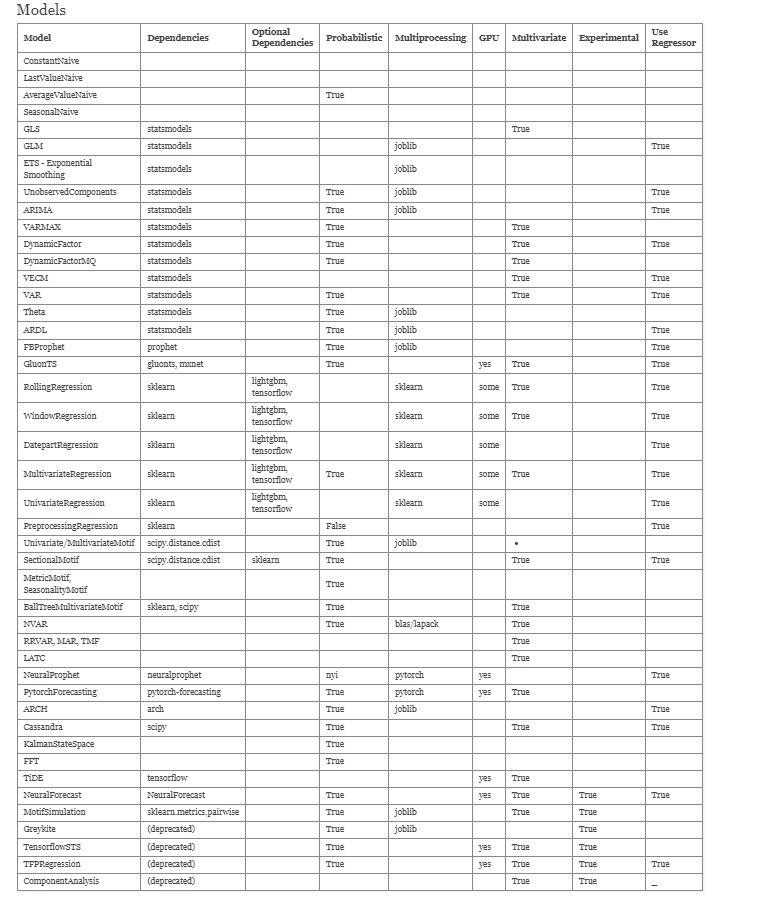

In [27]:
# Display an image
image_path = 'AUTOTS_modellist.png'  # Update with your image path
Image(filename=image_path)

In [28]:
# Set logging level to suppress less critical messages
logging.basicConfig(level=logging.ERROR)  # Adjust level as needed (ERROR, WARNING, INFO, DEBUG)
#this are the models available for univariate analysis
print(model_lists.keys())
print(model_lists['univariate'])


dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'fast_parallel_no_arima', 'scalable', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best', 'motifs', 'all_result_path', 'regressions', 'all_pragmatic', 'update_fit'])
['KalmanStateSpace', 'UnobservedComponents', 'GLM', 'DatepartRegression', 'MLEnsemble', 'GLS', 'UnivariateMotif', 'ARIMA', 'UnivariateRegression', 'ETS', 'Theta', 'LastValueNaive', 'SeasonalityMotif', 'FBProphet', 'ARCH', 'SeasonalNaive', 'MetricMotif', 'ConstantNaive', 'AverageValueNaive', 'FFT', 'NeuralProphet', 'ARDL', 'PreprocessingRegression']


#### 2.2.1 AUTOTS model evaluation
General assumptions:
- We have only evaluated models where AUTOARIMA did not perform as desired
- Eventhough it is recommended that the AUTOTS model has at least 50 observations in order to run better, for this study only country-animal combinations with less that 20 years of data have been discarded, so a sample size of 20 has been deemed sufficient
- To evaluate model performance the 95% CI has been used in the following way (the 95%CI could be changed to other CI value)
- The percentage of datapoints outside the CI have been counted.
     - The number of models with >20% of values outside the CI have been counted
     - The number of models with >30% of values outside the CI have been counted
     - The combination of country - animal that met both requirements above (i.e outside 95% CI> 20% or > 30%) have been stored for future evaluation
- Models where the prediction has returned a flat line (all values are the same), have not been considered into the model an a flag constant_prediction has been added to evaluate this models and why they may have failed
- The column Flag results reflects with type of model has been fitted (AUTOTS, constant, or No Data and Error), this is as well to check how many models couldn't been run because there was not enough data, how many models encountered and error, and how many models the training data was completely constant.
- The column Model_type defines the type of model selected by AUTOTS to run the data
- The models trialled have been ARIMA, FBProphet and ETS, for the trials where ensemble is set to true the combinations of this models have also been evaluated

#### 2.2.1.1 AUTOTS model evaluation with NO emsemble
For this analysis we are assuming emseble is set to None

<b> Select the Area- Item combinations where ARIMA did not perform well </b>


In [29]:
# Load the Excel file
excel_file = 'ARIMA_evaluation_results_all.xlsx'
df_results = pd.read_excel(excel_file)

# Filter the DataFrame for AutoARIMA and LASTVALUE
filtered_df_results = df_results[(df_results['Prediction Method'].isin(['AutoARIMA', 'AutoARIMA-Constant-Prediction'])) & (df_results['Predictions'] == 'LASTVALUE')]
filtered_df_results




,Country,Animal Type,Flag results,Constant Prediction,Mean Actual,Variance Actual,MAE,MSE,Proportion in CI,Prediction Method,Predictions,Flag,Model_type
0,Belarus,Goats,AutoARIMA,False,62320.0,4.057956e+07,1.891000e+04,4.601382e+08,0.0,AutoARIMA,LASTVALUE,AUTOARIMA-InsideCINotMet,AutoARIMA
1,Oman,Camels,AutoARIMA,False,265913.1,2.541215e+08,1.176543e+05,1.390812e+10,0.0,AutoARIMA,LASTVALUE,AUTOARIMA-InsideCINotMet,AutoARIMA
2,Ethiopia,Goats,AutoARIMA,False,38688821.5,9.805447e+13,1.621940e+07,3.644422e+14,0.0,AutoARIMA,LASTVALUE,AUTOARIMA-InsideCINotMet,AutoARIMA
3,Belarus,Horses,AutoARIMA,False,48210.0,4.134499e+08,1.087590e+05,1.696584e+10,0.0,AutoARIMA,LASTVALUE,AUTOARIMA-InsideCINotMet,AutoARIMA
4,Nigeria,Goats,AutoARIMA,False,78938455.3,3.742406e+13,2.453480e+07,7.239456e+14,0.0,AutoARIMA,LASTVALUE,AUTOARIMA-InsideCINotMet,AutoARIMA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157,Venezuela (Bolivarian Republic of),Horses,AutoARIMA,True,524170.8,7.846796e+06,4.388130e+03,2.631780e+07,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1158,Viet Nam,Buffalo,AutoARIMA,True,2425805.8,1.372576e+10,2.020072e+05,5.316009e+10,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1159,Viet Nam,Cattle,AutoARIMA,True,5770783.5,2.099124e+11,6.234224e+05,5.775767e+11,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA
1160,Yemen,Horses,AutoARIMA,True,1961.0,5.222889e+03,7.400000e+01,6.636600e+03,NaN,AutoARIMA-Constant-Prediction,LASTVALUE,AutoARIMA-Constant-Prediction,AutoARIMA


In [30]:
# Define the number of combinations to select
num_combinations = 2

# Randomly select a subset of country-animal combinations
# Get unique combinations of animal types and countries from the DataFrame
unique_combinations = filtered_df_results[['Country', 'Animal Type']].drop_duplicates()
# Randomly select a subset of unique country-animal combinations
random_combinations = unique_combinations.sample(num_combinations, replace=False, random_state=123)
evaluation_results = {}

# Please change the parameters as required
test_start_year = TEST_YEAR  # Specify the year to start testing
ensemble = None

# Initialize a dictionary to store error information
error_log = {}
df_autots = df.copy()
# Iterate over unique_combinations
with PdfPages('AUTOTS_forecast_plots.pdf') as pdf:
    for index, row in unique_combinations.iterrows():
        title_color = 'red'
        country = row['Country']
        animal_type = row['Animal Type']
     
        # predictions the DataFrame for the specific country and animal type combination
        filtered_df = df_autots[(df_autots['Area'] == country) & (df_autots['Item'] == animal_type)]
        
        try:
            
            results = evaluate_AUTOTS_model(df_autots, country, animal_type, ensemble=ensemble)   
            model_type, selected_model, constant_prediction, test_values, test_years, predictions, conf_int, proportion_in_ci = results
            evaluation_results[(country, animal_type)] = (model_type, selected_model, constant_prediction, proportion_in_ci)

         
            # Plot actual vs. predicted values
            plt.figure(figsize=(8, 4))
            plt.plot(filtered_df['Year'], filtered_df['Value'], label='Actual Data')

  

            if predictions is not None:
                plt.plot(test_years, predictions['Value'], label='Predicted Data')
                # Plot confidence intervals ensuring first that they are not None
                if conf_int is not None and not constant_prediction:
                    title_color = 'green'
                    plt.fill_between(test_years, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='Confidence Interval')

            plt.xlabel('Year')
            plt.ylabel('Population')
            title_text_obj = plt.title(f'{selected_model} prediction for {country} - {animal_type}')
            title_text_obj.set_color(title_color)
            plt.legend()
            plt.grid(True)

            # Save the current plot to the PDF
            pdf.savefig()
            plt.close()
        
        except Exception as e:
            # Log the error and continue to the next iteration
            error_log[(country, animal_type)] = str(e)
            # Plot actual vs. predicted values
            plt.figure(figsize=(8, 4))
            plt.plot(filtered_df['Year'], filtered_df['Value'], label='Actual Data')
            plt.xlabel('Year')
            plt.ylabel('Population')
            title_text_obj = plt.title(f'{selected_model} prediction for {country} - {animal_type}')
            title_text_obj.set_color(title_color)
            plt.legend()
            plt.grid(True)

            # Save the current plot to the PDF
            pdf.savefig()
            plt.close()
            continue

# After the loop, you can inspect the error_log if needed
print("Errors encountered:")
for key, error_message in error_log.items():
    print(f"For {key}: {error_message}")

Using 3 cpus for n_jobs.


DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:Adding TBB (C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.70154e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.70154e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


In [31]:
# Convert the dictionary to a DataFrame
data = {
    'Country': [],
    'Animal Type': [],
    'Flag results': [],
    'AutoTS model': [],
    'Constant Prediction': [],
    'Proportion in CI': []
}

for (country, animal_type), (model_type,selected_model, constant_prediction, proportion_in_ci) in evaluation_results.items():
    data['Country'].append(country)
    data['Animal Type'].append(animal_type)
    data['Flag results'].append(model_type)
    data['AutoTS model'].append(selected_model)
    data['Constant Prediction'].append(constant_prediction)
    data['Proportion in CI'].append(proportion_in_ci)

df_results = pd.DataFrame(data)
# Sort the DataFrame by 'Proportion in CI' column in ascending order
df_results_sorted = df_results.sort_values(by='Proportion in CI', ascending = True)

# Save the DataFrame to an Excel file
excel_file = 'AUTOTS_evaluation_results.xlsx'
df_results_sorted.to_excel(excel_file, index=False)

#print(f"DataFrame saved to {excel_file}")
df_results_sorted.tail(50)

,Country,Animal Type,Flag results,AutoTS model,Constant Prediction,Proportion in CI
304,Haiti,Horses,AutoTS,ARIMA,True,NaN
309,India,Cattle,AutoTS,ETS,True,NaN
311,Iran (Islamic Republic of),Asses,AutoTS,ARIMA,True,NaN
315,Iraq,Asses,AutoTS,ARIMA,True,NaN
316,Iraq,Camels,AutoTS,ARIMA,True,NaN
321,Ireland,Swine / pigs,AutoTS,ETS,True,NaN
322,Israel,Asses,AutoTS,ETS,True,NaN
323,Italy,Swine / pigs,AutoTS,ETS,True,NaN
324,Jamaica,Asses,AutoTS,ARIMA,True,NaN
325,Jamaica,Swine / pigs,AutoTS,ETS,True,NaN


In [32]:
# Define the path to your Excel file
excel_file = 'AUTOTS_evaluation_results.xlsx'

# Load the Excel file into a DataFrame
df_results = pd.read_excel(excel_file)


# Step 1: Merge Flag results and Constant Prediction into one column
df_results['Prediction Method'] = df_results.apply(lambda row: "Constant-Prediction" if row['Flag results'] == 'AutoTS' and row['Constant Prediction'] == True else f"{row['Flag results']}-{row['AutoTS model']}", axis=1)

# Step 2: Create Predictions column based on conditions
df_results['Predictions'] = df_results.apply(lambda row: 'MODEL' if row['Flag results'] == 'AutoTS' and not row['Constant Prediction'] and row['Proportion in CI'] >= PROP_IN_CI_DESIRED else 'LASTVALUE', axis=1)

df_results['Flag'] = df_results['Prediction Method']


# Update 'Flag' column based on conditions
df_results.loc[(df_results['Proportion in CI'] < PROP_IN_CI_DESIRED) & (df_results['Flag results'] == 'AutoTS'), 'Flag'] = 'InsideCINotMet'


# Assuming df_results is your DataFrame
df_results['Model_type'] = df_results.apply(lambda row: 'AutoTS ' + row['AutoTS model'] if row['Flag results'] == 'AutoTS' else 'None', axis=1)

df_results.head(40)

,Country,Animal Type,Flag results,AutoTS model,Constant Prediction,Proportion in CI,Prediction Method,Predictions,Flag,Model_type
0,Costa Rica,Horses,AutoTS,FBProphet,False,0.0,AutoTS-FBProphet,LASTVALUE,InsideCINotMet,AutoTS FBProphet
1,Ethiopia,Asses,AutoTS,FBProphet,False,0.0,AutoTS-FBProphet,LASTVALUE,InsideCINotMet,AutoTS FBProphet
2,Greece,Goats,AutoTS,ARIMA,False,0.0,AutoTS-ARIMA,LASTVALUE,InsideCINotMet,AutoTS ARIMA
3,Qatar,Cattle,AutoTS,ETS,False,0.0,AutoTS-ETS,LASTVALUE,InsideCINotMet,AutoTS ETS
4,Poland,Goats,AutoTS,FBProphet,False,0.0,AutoTS-FBProphet,LASTVALUE,InsideCINotMet,AutoTS FBProphet
5,Germany,Buffalo,AutoTS,ARIMA,False,0.0,AutoTS-ARIMA,LASTVALUE,InsideCINotMet,AutoTS ARIMA
6,Republic of Moldova,Horses,AutoTS,ARIMA,False,0.0,AutoTS-ARIMA,LASTVALUE,InsideCINotMet,AutoTS ARIMA
7,Chad,Sheep,AutoTS,FBProphet,False,0.0,AutoTS-FBProphet,LASTVALUE,InsideCINotMet,AutoTS FBProphet
8,Slovakia,Swine / pigs,AutoTS,ARIMA,False,0.0,AutoTS-ARIMA,LASTVALUE,InsideCINotMet,AutoTS ARIMA
9,New Caledonia,Swine / pigs,AutoTS,FBProphet,False,0.0,AutoTS-FBProphet,LASTVALUE,InsideCINotMet,AutoTS FBProphet


In [33]:
# Save the DataFrame to an Excel file
excel_file = 'AUTOTS_evaluation_results_all.xlsx'
df_results.to_excel(excel_file, index=False)



#### 2.2.1.1.1 Count Models with Proportions in CI

In [34]:
df_sorted = df_results[df_results['Proportion in CI'].notna()]
# Count models with proportion in CI > PROP_IN_CI_DESIRED and > PROP_IN_CI_ALLOWED
count_greater_than_p_desired = df_sorted[df_sorted['Proportion in CI'] >= PROP_IN_CI_DESIRED].shape[0]
count_greater_than_p_allowed = df_sorted[df_sorted['Proportion in CI'] >= PROP_IN_CI_ALLOWED].shape[0]

# Calculate the proportion of models with Proportion in CI > PROP_IN_CI_DESIRED% and > PROP_IN_CI_ALLOWED%
proportion_in_ci_pdesired = ((df_sorted['Proportion in CI'] >= PROP_IN_CI_DESIRED).mean() * 100).round(2)
# Calculate the proportion of models with Proportion in CI > ci_threshold
proportion_in_ci_pallowed = ((df_sorted['Proportion in CI'] >= PROP_IN_CI_ALLOWED).mean() * 100).round(2)


print(f"Models with proportion in CI >= {PROP_IN_CI_DESIRED*100}%: {count_greater_than_p_desired} and the proportion of models is {proportion_in_ci_pdesired}")
print(f"Models with proportion in CI >=  {PROP_IN_CI_ALLOWED*100}%: {count_greater_than_p_allowed} and the proportion of models is {proportion_in_ci_pallowed}")

# perform this per specie 

Models with proportion in CI >= 80.0%: 190 and the proportion of models is 49.87
Models with proportion in CI >=  70.0%: 204 and the proportion of models is 53.54


#### 2.1.1.1.2 Describe Counts of Constant Prediction Models

In [35]:
# Describe counts of constant prediction models
# Count occurrences of constant predictions
df_sorted = df_results
constant_prediction_counts = df_sorted['Constant Prediction'].value_counts()

# Calculate proportions
total_predictions = len(df_sorted)
flag_results_proportions = ((constant_prediction_counts / total_predictions) * 100).round(2)

print("Counts of Constant Prediction:")
print(constant_prediction_counts)

print("\nProportion of Constant Prediction:")
print(flag_results_proportions)

Counts of Constant Prediction:
Constant Prediction
False    387
True      88
Name: count, dtype: int64

Proportion of Constant Prediction:
Constant Prediction
False    81.47
True     18.53
Name: count, dtype: float64


#### 2.1.1.1.3 Describe Counts for each "Flag Results" category

In [36]:

# Count occurrences of each 'Flag results' category
flag_results_counts = df_sorted['Flag results'].value_counts()

# Calculate proportions
total_results = len(df_sorted)
flag_results_proportions = ((flag_results_counts / total_results) * 100).round(2)

print("Counts for each 'Flag results' category:")
print(flag_results_counts)

print("\nProportions for each 'Flag results' category:")
print(flag_results_proportions)

Counts for each 'Flag results' category:
Flag results
AutoTS           469
Unknown Model      6
Name: count, dtype: int64

Proportions for each 'Flag results' category:
Flag results
AutoTS           98.74
Unknown Model     1.26
Name: count, dtype: float64


#### 2.2.1.2 AUTOTS model evaluation with  emsemble

<b> Select the Area- Item combinations where non esemble did not perform well </b>


In [4]:
# Load the Excel file
excel_file = 'AUTOTS_evaluation_results_all.xlsx'
df_results = pd.read_excel(excel_file)

# Filter the DataFrame for AutoARIMA and LASTVALUE
filtered_df_results = df_results[(df_results['Predictions'] == 'LASTVALUE')]
filtered_df_results





,Country,Animal Type,Flag results,AutoTS model,Constant Prediction,Proportion in CI,Prediction Method,Predictions,Flag,Model_type
0,Costa Rica,Horses,AutoTS,FBProphet,False,0.0,AutoTS-FBProphet,LASTVALUE,InsideCINotMet,AutoTS FBProphet
1,Ethiopia,Asses,AutoTS,FBProphet,False,0.0,AutoTS-FBProphet,LASTVALUE,InsideCINotMet,AutoTS FBProphet
2,Greece,Goats,AutoTS,ARIMA,False,0.0,AutoTS-ARIMA,LASTVALUE,InsideCINotMet,AutoTS ARIMA
3,Qatar,Cattle,AutoTS,ETS,False,0.0,AutoTS-ETS,LASTVALUE,InsideCINotMet,AutoTS ETS
4,Poland,Goats,AutoTS,FBProphet,False,0.0,AutoTS-FBProphet,LASTVALUE,InsideCINotMet,AutoTS FBProphet
...,...,...,...,...,...,...,...,...,...,...
470,Türkiye,Cattle,AutoTS,ETS,True,NaN,Constant-Prediction,LASTVALUE,Constant-Prediction,AutoTS ETS
471,Türkiye,Sheep,AutoTS,ETS,True,NaN,Constant-Prediction,LASTVALUE,Constant-Prediction,AutoTS ETS
472,Ukraine,Camels,AutoTS,ETS,True,NaN,Constant-Prediction,LASTVALUE,Constant-Prediction,AutoTS ETS
473,United Kingdom,Sheep,AutoTS,ETS,True,NaN,Constant-Prediction,LASTVALUE,Constant-Prediction,AutoTS ETS


In [ ]:
# Define the number of combinations to select
num_combinations = 2

# Randomly select a subset of country-animal combinations
# Get unique combinations of animal types and countries from the DataFrame
unique_combinations = filtered_df_results[['Country', 'Animal Type']].drop_duplicates()
# Randomly select a subset of unique country-animal combinations
random_combinations = unique_combinations.sample(num_combinations, replace=False, random_state=123)
evaluation_results = {}

# Please change the parameters as required
test_start_year = TEST_YEAR  # Specify the year to start testing
ensemble = 'simple'

# Initialize a dictionary to store error information
error_log = {}
df_autots = df.copy()
# Iterate over unique_combinations
with PdfPages('AUTOTS_forecast_plots_emsemble.pdf') as pdf:
    for index, row in unique_combinations.iterrows():
        title_color = 'red'
        country = row['Country']
        animal_type = row['Animal Type']
     
        # predictions the DataFrame for the specific country and animal type combination
        filtered_df = df_autots[(df_autots['Area'] == country) & (df_autots['Item'] == animal_type)]
        
        try:
            
            results = evaluate_AUTOTS_model(df_autots, country, animal_type, ensemble=ensemble)   
            model_type, selected_model, constant_prediction, test_values, test_years, predictions, conf_int, proportion_in_ci = results
            evaluation_results[(country, animal_type)] = (model_type, selected_model, constant_prediction, proportion_in_ci)

         
            # Plot actual vs. predicted values
            plt.figure(figsize=(8, 4))
            plt.plot(filtered_df['Year'], filtered_df['Value'], label='Actual Data')

  

            if predictions is not None:
                plt.plot(test_years, predictions['Value'], label='Predicted Data')
                # Plot confidence intervals ensuring first that they are not None
                if conf_int is not None and not constant_prediction:
                    title_color = 'green'
                    plt.fill_between(test_years, conf_int[:, 0], conf_int[:, 1], color='gray', alpha=0.2, label='Confidence Interval')

            plt.xlabel('Year')
            plt.ylabel('Population')
            title_text_obj = plt.title(f'{selected_model} prediction for {country} - {animal_type}')
            title_text_obj.set_color(title_color)
            plt.legend()
            plt.grid(True)

            # Save the current plot to the PDF
            pdf.savefig()
            plt.close()
        
        except Exception as e:
            # Log the error and continue to the next iteration
            error_log[(country, animal_type)] = str(e)
            # Plot actual vs. predicted values
            plt.figure(figsize=(8, 4))
            plt.plot(filtered_df['Year'], filtered_df['Value'], label='Actual Data')
            plt.xlabel('Year')
            plt.ylabel('Population')
            title_text_obj = plt.title(f'{selected_model} prediction for {country} - {animal_type}')
            title_text_obj.set_color(title_color)
            plt.legend()
            plt.grid(True)

            # Save the current plot to the PDF
            pdf.savefig()
            plt.close()
            continue

# After the loop, you can inspect the error_log if needed
print("Errors encountered:")
for key, error_message in error_log.items():
    print(f"For {key}: {error_message}")

Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.70154e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Using 3 cpus for n_jobs.


ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.70154e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


C:\Users\egh22\AppData\Roaming\Python\Python311\site-packages\autots\tools\percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.
Using 3 cpus for n_jobs.


In [ ]:
# Convert the dictionary to a DataFrame
data = {
    'Country': [],
    'Animal Type': [],
    'Flag results': [],
    'AutoTS model': [],
    'Constant Prediction': [],
    'Proportion in CI': []
}

for (country, animal_type), (model_type,selected_model, constant_prediction, proportion_in_ci) in evaluation_results.items():
    data['Country'].append(country)
    data['Animal Type'].append(animal_type)
    data['Flag results'].append(model_type)
    data['AutoTS model'].append(selected_model)
    data['Constant Prediction'].append(constant_prediction)
    data['Proportion in CI'].append(proportion_in_ci)

df_results = pd.DataFrame(data)
# Sort the DataFrame by 'Proportion in CI' column in ascending order
df_results_sorted = df_results.sort_values(by='Proportion in CI', ascending = True)

# Save the DataFrame to an Excel file
excel_file = 'AUTOTS_evaluation_results_withensemble.xlsx'
df_results_sorted.to_excel(excel_file, index=False)

#print(f"DataFrame saved to {excel_file}")
df_results_sorted.head(50)

In [ ]:
# Define the path to your Excel file
excel_file = 'AUTOTS_evaluation_results_withensemble.xlsx'

# Load the Excel file into a DataFrame
df_results = pd.read_excel(excel_file)


# Step 1: Merge Flag results and Constant Prediction into one column
df_results['Prediction Method'] = df_results.apply(lambda row: f"{row['Flag results']}-Constant-Prediction" if row['Flag results'] == 'AUTOTS' and row['Constant Prediction'] else f"{row['Flag results']}-{row['AutoTS model']}", axis=1)

# Step 2: Create Predictions column based on conditions
df_results['Predictions'] = df_results.apply(lambda row: 'MODEL' if row['Flag results'] == 'AutoTS' and not row['Constant Prediction'] and row['Proportion in CI'] >= PROP_IN_CI_DESIRED else 'LASTVALUE', axis=1)


df_results['Flag'] = df_results['Prediction Method']


# Update 'Flag' column based on conditions
df_results.loc[(df_results['Proportion in CI'] < PROP_IN_CI_DESIRED) & (df_results['Flag results'] == 'AutoTS'), 'Flag'] = 'AUTOTS-InsideCINotMet'

# Assuming df_results is your DataFrame
# Update 'Model_type' based on conditions
df_results['Model_type'] = df_results.apply(lambda row: f"AutoTS {row['AutoTS model']}" if row['Flag results'] == 'AutoTS' and not pd.isnull(row['AutoTS model']) else 'None', axis=1)

# Change 'Flag results' from 'AutoTS' to 'AutoTS-ensemble'
df_results.loc[df_results['Flag results'] == 'AutoTS', 'Flag results'] = 'AutoTS-ensemble'

df_results.head(15)


In [ ]:
# Save the DataFrame to an Excel file
excel_file = 'AUTOTS_evaluation_results_ensemble_all.xlsx'
df_results.to_excel(excel_file, index=False)



#### 2.2.1.2.1 Count Models with Proportions in CI

In [ ]:
df_sorted = df_results[df_results['Proportion in CI'].notna()]
# Count models with proportion in CI > PROP_IN_CI_DESIRED and > PROP_IN_CI_ALLOWED
count_greater_than_p_desired = df_sorted[df_sorted['Proportion in CI'] >= PROP_IN_CI_DESIRED].shape[0]
count_greater_than_p_allowed = df_sorted[df_sorted['Proportion in CI'] >= PROP_IN_CI_ALLOWED].shape[0]

# Calculate the proportion of models with Proportion in CI > PROP_IN_CI_DESIRED% and > PROP_IN_CI_ALLOWED%
proportion_in_ci_pdesired = ((df_sorted['Proportion in CI'] >= PROP_IN_CI_DESIRED).mean() * 100).round(2)
# Calculate the proportion of models with Proportion in CI > ci_threshold
proportion_in_ci_pallowed = ((df_sorted['Proportion in CI'] >= PROP_IN_CI_ALLOWED).mean() * 100).round(2)


print(f"Models with proportion in CI >= {PROP_IN_CI_DESIRED*100}%: {count_greater_than_p_desired} and the proportion of models is {proportion_in_ci_pdesired}")
print(f"Models with proportion in CI >=  {PROP_IN_CI_ALLOWED*100}%: {count_greater_than_p_allowed} and the proportion of models is {proportion_in_ci_pallowed}")


#### 2.1.1.2.2 Describe Counts of Constant Prediction Models 

In [ ]:
# Describe counts of constant prediction models
# Count occurrences of constant predictions
df_sorted = df_results
constant_prediction_counts = df_sorted['Constant Prediction'].value_counts()

# Calculate proportions
total_predictions = len(df_sorted)
flag_results_proportions = ((constant_prediction_counts / total_predictions) * 100).round(2)

print("Counts of Constant Prediction:")
print(constant_prediction_counts)

print("\nProportion of Constant Prediction:")
print(flag_results_proportions)

#### 2.1.1.2.3 Describe Counts for each "Flag Results" category

In [ ]:
# Count occurrences of each 'Flag results' category
flag_results_counts = df_sorted['Flag results'].value_counts()

# Calculate proportions
total_results = len(df_sorted)
flag_results_proportions = ((flag_results_counts / total_results) * 100).round(2)

print("Counts for each 'Flag results' category:")
print(flag_results_counts)

print("\nProportions for each 'Flag results' category:")
print(flag_results_proportions)